In this exploratory analysis and initial prediction, I've used:
- pandas for exploration and manipulation.
    - The dataframes fit in memory, and it offers great integration with plotting and ML tools, alongside very easy manipulation of data
- scikit-learn package for machine learning models and testing framework
    - Great for prototyping simple models and viewing underlying relationships of features
    - Easy validation/assessment of models
- matplotlib/seaborn for plotting
    - This is the plotting library I'm most familiar with

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import timedelta

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
user_info_path = "assessment_data/user_info.csv"
chapters_read_path = "assessment_data/chapters_read.csv"
questions_read_path = "assessment_data/questions_read.csv"
code_activations_path = "assessment_data/code_activations.csv"

In [4]:
df_user_info = pd.read_csv(user_info_path)
df_chapters_read = pd.read_csv(chapters_read_path)
df_questions_read = pd.read_csv(questions_read_path)
df_code_activations = pd.read_csv(code_activations_path)

# force all time columns to be datetime type
df_user_info['register_date'] = pd.to_datetime(df_user_info['register_date'])
df_chapters_read['created_at'] = pd.to_datetime(df_chapters_read['created_at'])
df_questions_read['created_at'] = pd.to_datetime(df_questions_read['created_at'])
df_code_activations['code_activation'] = pd.to_datetime(df_code_activations['code_activation'])

### Initial look at the tables

In [5]:
df_user_info.head(3)

,user_id,country_id,next_exam_type,marketing_source,signup_device,signup_os,activated,register_date
0,1079934,AU,NaN,conference,desktop,Windows,1,2017-10-01 01:55:57
1,1080081,AU,NaN,facebook,desktop,Windows,1,2017-10-01 10:08:21
2,1080241,US,step-1,facebook,desktop,Macintosh,1,2017-10-01 19:01:47


In [6]:
df_chapters_read.head(3)

,user_id,created_at,referer,time_spent,chapter_id,subjects
0,1079979,2017-10-01 05:26:30,library,NaN,274,"['Occupational medicine，social medicine', 'Pne..."
1,1079979,2017-10-01 05:26:37,library,NaN,269,"['Imaging，radiotherapy，radiation protection', ..."
2,1079946,2017-10-01 05:27:56,library,NaN,622,"['Infectiology', 'Otolaryngology', 'Pediatrics']"


In [7]:
df_questions_read.head(3)

,user_id,question_id,answer_id,collection_id,created_at,was_answer_correct,is_completed,has_given_up,time_spent,used_highlight,used_case_highlight,used_hint_as_help,used_hint_as_nonsense,chapter_ids
0,1086402,80,403.0,65022,2017-10-19 06:01:58,1,1,0,85,0,0,0,0,[288]
1,1102210,2202,NaN,87830,2017-11-29 05:26:42,0,1,1,3,0,0,0,0,"[1304, 29, 1155, 1313, 1343, 25]"
2,1101933,692,4112.0,86026,2017-11-25 06:50:36,1,1,0,5,0,0,0,0,[1189]


In [8]:
df_code_activations.head(3)

,user_id,code_activation
0,1079921,2017-10-01 00:58:03
1,1079933,2017-10-01 01:51:48
2,1079985,2017-10-01 05:39:42


## Data exploration and cleaning

### User info table

There are a significant number of users which are not activated - more discussion on this below

In [9]:
df_user_info['activated'].value_counts()

1    35588
0     8195
Name: activated, dtype: int64

The majority of users do not have a known marketing source, this needs a reasonable treatment

In [10]:
df_user_info['marketing_source'].fillna("unknown").value_counts()

unknown              24538
facebook              6415
friends               4567
advertisement         2417
google                1813
press_online          1339
university             908
conference             638
other                  475
youtube                324
students_work          287
student_committee       27
library                 20
flyer                   13
amazon                   1
bookstore                1
Name: marketing_source, dtype: int64

### Non-attributed and un-activated users
- Here we investigate the un-activated users, and those with no marketing_source
- These users may need to be removed, or they could be from organic sources (no marketing action involved) 
- If they are from organic sources, they could provide a good benchmark to rank the marketing channels against

In [11]:
# number of users which are not activated and have no marketing_source
num_unactivated_nullmartketing_users = \
    len(df_user_info[(df_user_info['activated']==0) & (pd.isnull(df_user_info['marketing_source']))])
    
# number of users where marketing_source is empty    
num_nullmarketing_users = len(df_user_info[pd.isnull(df_user_info['marketing_source'])])
    
# number users which are not activated
num_unactivated_users = len(df_user_info[df_user_info['activated']==0])

pct_unactivated_users_with_nomarketing = \
    (num_unactivated_nullmartketing_users / \
    num_unactivated_users) * 100
    
pct_nomarketing_of_unactivated_users = \
    (num_unactivated_nullmartketing_users / \
    num_nullmarketing_users) * 100
    
print("Percentage of unactivated users which have no marketing_source: {}%"\
      .format(round(pct_unactivated_users_with_nomarketing, 2)))

print("Percentage of users with no marketing_source which have not activated: {}%"\
      .format(round(pct_nomarketing_of_unactivated_users, 2)))

# Important to check which null marketing users actually use the service

Percentage of unactivated users which have no marketing_source: 97.47%
Percentage of users with no marketing_source which have not activated: 32.55%


In [12]:
# look at the activation rates per channel
df_pct_activated_per_channel = \
    df_user_info.groupby('marketing_source').agg({"activated":"sum", "user_id":"count"})
    
df_pct_activated_per_channel['pct_activated'] = \
    round((df_pct_activated_per_channel['activated'] / df_pct_activated_per_channel['user_id'])*100, 2)
    
df_pct_activated_per_channel # all channels have nearly 100% activation rates

,activated,user_id,pct_activated
marketing_source,,,
advertisement,2388,2417,98.80
amazon,1,1,100.00
bookstore,1,1,100.00
conference,627,638,98.28
facebook,6366,6415,99.24
flyer,13,13,100.00
friends,4512,4567,98.80
google,1788,1813,98.62
library,20,20,100.00


#### In summary:
- Nearly all unactivated users have no marketing_source, which is curious
- Just one third of users with no marketing_source have not activated.
- Some of the no marketing_source users have activity in the other tables (chapters and questions)
- All other marketing sources have (close to) 100% activation rates

#### Based on this, we will assume:
- Un-activated users do not contain any useful information,so we can remove them
- We should give the activated users with no marketing_source the tag 'unknown', as these could be organic users, and may provide a helpful benchmark to rank the other channels

In [13]:
# removing un-activated users 
df_user_info = df_user_info[df_user_info['activated']==1]
df_user_info['marketing_source'] = \
    df_user_info['marketing_source'].loc[:].fillna("unknown")

## Registrations and usage per day

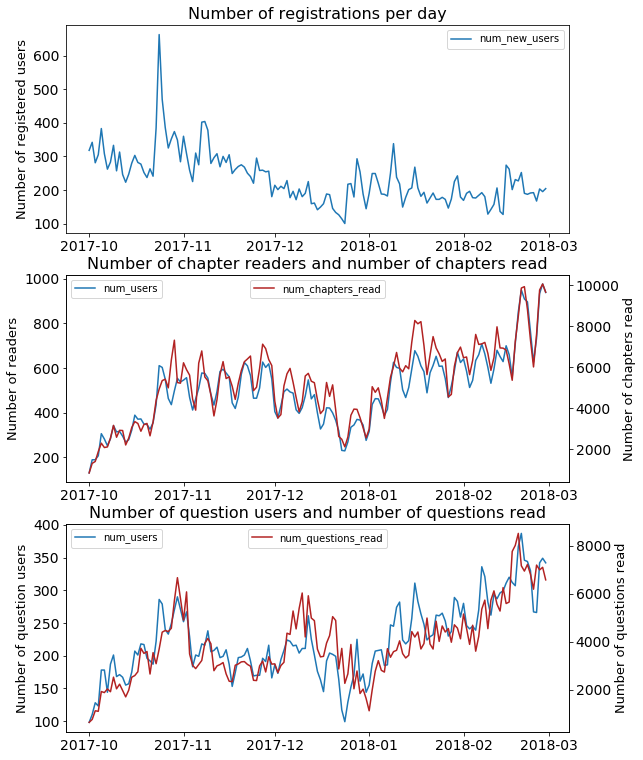

In [14]:
f = plt.figure(figsize=(9,13))
ax = f.add_subplot(311)
ax1 = f.add_subplot(312, sharex=ax)
ax2 = f.add_subplot(313, sharex=ax)

# Plotting timeline of how many registrations per day
df_user_info['register_day'] = df_user_info['register_date'].dt.date
df_chapters_read['read_day'] = df_chapters_read['created_at'].dt.date
df_questions_read['read_day'] = df_questions_read['created_at'].dt.date
users_per_day = df_user_info.groupby("register_day")['user_id'].nunique()

#plot users registering per day
ax.plot(users_per_day.index, users_per_day.values, label="num_new_users")
ax.tick_params(axis="both", labelsize=14)
ax.set_ylabel("Number of registered users", size=13)
ax.set_title("Number of registrations per day", size=16)
ax.legend()

# plot users reading chapters per day
ax1_1 = ax1.twinx()
chapters_users_per_day = df_chapters_read.groupby("read_day").agg({'user_id':'nunique', "chapter_id":"count"})
ax1.plot(chapters_users_per_day.index, chapters_users_per_day['user_id'], label="num_users")
ax1_1.plot(chapters_users_per_day.index, chapters_users_per_day['chapter_id'], label="num_chapters_read", color="firebrick")
ax1.tick_params(axis="both", labelsize=14)
ax1_1.tick_params(axis="both", labelsize=14)
ax1.set_ylabel("Number of readers", size=13)
ax1_1.set_ylabel("Number of chapters read", size=13)
ax1.set_title("Number of chapter readers and number of chapters read", size=16)
ax1.legend(loc=2)
ax1_1.legend(loc=9)

#plot users answering questions per day
ax2_2 = ax2.twinx()
questions_users_per_day = df_questions_read.groupby("read_day").agg({'user_id':'nunique', "question_id":"count"})
ax2.plot(chapters_users_per_day.index, questions_users_per_day['user_id'], label="num_users")
ax2_2.plot(chapters_users_per_day.index, questions_users_per_day['question_id'], label="num_questions_read", color="firebrick")
ax2.tick_params(axis="both", labelsize=14)
ax2_2.tick_params(axis="both", labelsize=14)
ax2.set_ylabel("Number of question users", size=13)
ax2_2.set_ylabel("Number of questions read", size=13)
ax2.set_title("Number of question users and number of questions read", size=16)
ax2.legend(loc=2)
ax2_2.legend(loc=9)

There is a sharp increase in registrations on the 24th of October. However, this is a cross-channel increase (all channels increase by the same amount), so it is either as a result of a cross-channel promotion, or as a result of the dataset sampling. In either case, we may need to bear this in mind when creating our model.


For the first half of the dataset, the trend of chapters read and questions answered generally follows that of the number of registrations. However, it appears that the usage per user increases from the beginning of 2018 onward. This is worth bearing in mind, and investigating in the future if this extra activity is from the new users or from the existing.

In [15]:
#most referers are the mobile app
df_chapters_read['referer'].value_counts()

vesikel    511444
library    232172
walk        49800
unknown      1824
public        186
Name: referer, dtype: int64

## Investigating definition of 'active user'
- Definition could include code activations:
    - Vast majority of users in the set only activate one code. 

- Need to investigate for how many days these single-code users are answering questions. 
- There could be users which are active for longer, but do not buy a code.

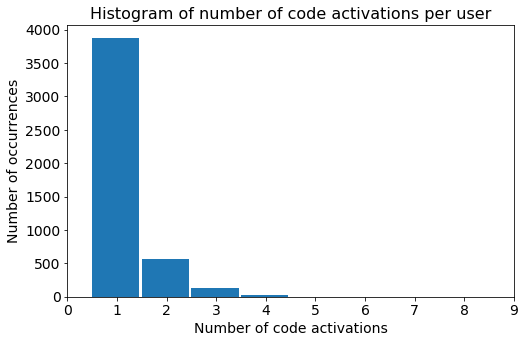

In [16]:
# plot how many codes each user activates
code_activations_per_user = df_code_activations.groupby("user_id").count()['code_activation']
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(code_activations_per_user, 
        align="left", 
        bins=[x for x in range(0, code_activations_per_user.max()+1)],
       width=0.95)
ax.tick_params(labelsize=14, axis="both")
ax.set_title("Histogram of number of code activations per user", size=16)
ax.set_ylabel("Number of occurrences", size=14)
ax.set_xlabel("Number of code activations", size=14)
ax.set_xlim(0, code_activations_per_user.max()+1)
plt.show()

### Checking activity of users with one code activation
- There are ~1000 single-code users with more than 5 days of question activity
    - This is a strange behaivour, and seems contrary to the definitions provided
- There are also ~2000 single-code users with more than 5 days of chapter activity
    - Also a strange behaviour given the defnitions
    
    
- As a result, just checking for code activations is not sufficient
- Definition of active user will also include questions answered and chapters read at least 5 days on from the signup date

In [17]:
single_code_users = code_activations_per_user[code_activations_per_user==1].index.tolist()

In [18]:
df_single_code_user_questions = \
    df_questions_read[df_questions_read['user_id'].isin(single_code_users)]
    
df_user_activity_times = df_single_code_user_questions.groupby("user_id").agg({"created_at":["max", "min"], "question_id":"count"})
df_user_activity_times['activity_time'] = df_user_activity_times['created_at']['max'] - df_user_activity_times['created_at']['min']
df_user_activity_times['num_activity_days'] = df_user_activity_times['activity_time'].dt.days

df_singlecode_morethan5days_users = \
    df_user_activity_times[df_user_activity_times['num_activity_days']>5]
    
print("""There are {} user_ids which have only redeemed 1 code, \
but answered questions more than 5 days apart"""\
      .format(len(df_singlecode_morethan5days_users)))

median_singlecode_num_questions = df_singlecode_morethan5days_users['question_id']['count'].median()

print("The median number of questions answered by those users is: {}".format(int(median_singlecode_num_questions)))

There are 1012 user_ids which have only redeemed 1 code, but answered questions more than 5 days apart
The median number of questions answered by those users is: 74


In [19]:
df_single_code_user_chapters = \
    df_chapters_read[df_chapters_read['user_id'].isin(single_code_users)]
    
df_user_chapter_times = df_single_code_user_chapters.groupby("user_id").agg({"created_at":["max", "min"], "chapter_id":"count"})
df_user_chapter_times['activity_time'] = df_user_chapter_times['created_at']['max'] - df_user_chapter_times['created_at']['min']
df_user_chapter_times['num_activity_days'] = df_user_chapter_times['activity_time'].dt.days

df_singlecode_morethan5days_chapter_users = \
    df_user_chapter_times[df_user_chapter_times['num_activity_days']>5]
    
print("""There are {} user_ids which have only redeemed 1 code, \
but answered questions more than 5 days apart"""\
      .format(len(df_singlecode_morethan5days_chapter_users)))

median_singlecode_num_questions = df_singlecode_morethan5days_chapter_users['chapter_id']['count'].median()

print("The median number of chapters by those users is: {}".format(int(median_singlecode_num_questions)))

There are 2027 user_ids which have only redeemed 1 code, but answered questions more than 5 days apart
The median number of chapters by those users is: 52


## Active user definition
Definition needs to include users which have only activated one code, but have chapter and question activity
- As the median number of questions answered by these users is 74, we will eyeball this to 20 questions answered after the initial 5 days. This can be changed later
- The median number of chapters read is 52, so this will be reduced by estimation to 5 chapters read after the initial 5 days

The definition will have 2 conditions. If a user meets either one of these conditions, then they will be classified as 'active'
    - The user redeems more than two codes at least 6 days after their signup date
    OR
    - The user reads 20 questions after their trial period expires, AND have activated one code
        AND
    - The user reads at least 5 chapters after their trial period expires, AND have activated one code

In [20]:
# list of users from condition 1
multiple_code_users = []
for user_id in df_user_info['user_id'].unique():
    signup_date = df_user_info.loc[df_user_info['user_id']==user_id]['register_date'].values[0]
    next_code_time = signup_date + pd.Timedelta("6 days")
    df_user_codes = \
        df_code_activations[df_code_activations['user_id']==user_id].sort_values("code_activation")
    df_user_codes = df_user_codes[df_user_codes['code_activation']>=next_code_time]
    if len(df_user_codes) >= 2:
        multiple_code_users.append(user_id)
        
#list of users from condition 2
morethan5days_users = \
    df_singlecode_morethan5days_users[\
    df_singlecode_morethan5days_users['question_id']['count'] >= 20]\
    .index.tolist()

#list of users from condition 3
morethan5days_chapter_users = \
    df_singlecode_morethan5days_chapter_users[\
    df_singlecode_morethan5days_chapter_users['chapter_id']['count'] >= 5]\
    .index.tolist()

In [22]:
active_users = set(multiple_code_users + list(set(morethan5days_users).intersection(morethan5days_chapter_users)))
len(active_users)

972

## Prediction outline
We will create a binary flag for 'active user' using the definition given above. Following this, we will:
- Attempt a binary prediction/classification of a user into active/inactive based on the first 2/3 days of usage
- For the active users, we will then try to predict over the next 6 months:
    - Will they activate multiple codes
    - How many chapters they will read
    - How many questions they will answer

## Creating prediction matrix
- We will only consider users which appear in the questions_read table for inclusion, as there are too many users which did not make it that far. It also may not make sense to target users which did not even use the question functionality of the product. These users could be targeted in a different, future analysis.
- We will gather metrics for the first 3 days of each user's activity:
    - 'num_questions_answered'
    - 'num_unique_questions_answered', 
    - 'num_questions_repeated', 
    - 'num_correct_answers', 
    - 'num_incorrect_answers',
    - 'frac_correct_answers', 
    - 'num_given_up',
    - 'num_used_highlights_hints', 
    - 'num_questions_last_day', 
    - 'num_chapters_read', 
    - 'num_unique_chapters'
    - 'num_chapters_repeated'

In [23]:
first_days_results_list = []
num_days = 3
for user_id in df_questions_read['user_id'].unique():
    #filter questions and chapters down to each user
    df_user_questions = \
        df_questions_read[df_questions_read['user_id']==user_id].sort_values("created_at")
    df_user_chapters = \
        df_chapters_read[df_chapters_read["user_id"] == user_id].sort_values("created_at")
        
    #find the first time they use it, and num_days later    
    first_use = df_user_questions['created_at'].values[0]
    end_time = first_use + pd.Timedelta("{} days".format(int(num_days)))
    
    # create dataframes for the first 2/3 (however many chosen) days
    df_user_questions_first_days = \
        df_user_questions[df_user_questions["created_at"] <= end_time]
    if len(df_user_questions_first_days) == 0:
        continue
    df_user_chapters_first_days = \
        df_chapters_read[df_chapters_read["created_at"] <= end_time]
        
    #statistics from the questions table
    num_questions_answered = len(df_user_questions_first_days['question_id'].dropna())
    num_unique_questions_answered = df_user_questions_first_days['question_id'].nunique()
    num_questions_repeated = num_questions_answered - num_unique_questions_answered
    num_correct_answers = df_user_questions_first_days['was_answer_correct'].sum()
    num_incorrect_answers = num_questions_answered - num_correct_answers
    frac_correct_answers = num_correct_answers / num_questions_answered
    num_given_up = df_user_questions_first_days['has_given_up'].sum()
    num_used_highlights_hints = df_user_questions_first_days['used_highlight'].sum() \
                              + df_user_questions_first_days['used_case_highlight'].sum() \
                              + df_user_questions_first_days['used_hint_as_help'].sum() \
                              + df_user_questions_first_days['used_hint_as_nonsense'].sum()  
    num_questions_last_day = \
        len(df_user_questions_first_days[df_user_questions_first_days['created_at'] >= 
                                     end_time - pd.Timedelta("1 days")])
        
    #statistics from the chapters table
    num_chapters_read = len(df_user_chapters_first_days['chapter_id'].dropna())
    num_unique_chapters = df_user_chapters_first_days['chapter_id'].nunique()
    num_chapters_repeated = num_chapters_read - num_unique_chapters

    # bring into an ordered list
    user_results_list = [user_id, num_questions_answered, num_unique_questions_answered, num_questions_repeated,
                        num_correct_answers, num_incorrect_answers, frac_correct_answers, num_given_up, 
                         num_used_highlights_hints, num_questions_last_day,
                        num_chapters_read, num_unique_chapters, num_chapters_repeated] 
    #add to results list of lists
    first_days_results_list.append(user_results_list)   
    
#make dataframe from list of lists    
df_first_days = pd.DataFrame(first_days_results_list, 
                               columns=['user_id', 'num_questions_answered', 
                                        'num_unique_questions_answered', 
                                        'num_questions_repeated', 'num_correct_answers', 
                                        'num_incorrect_answers',
                                        'frac_correct_answers', 'num_given_up',
                                        'num_used_highlights_hints', 
                                        'num_questions_last_day', 'num_chapters_read', 
                                        'num_unique_chapters', 'num_chapters_repeated'])


In [24]:
# add active_user column, and marketing_source column
df_first_days['active_user'] = df_first_days['user_id'].apply(lambda user: 1 if user in active_users else 0)
df_first_days = df_first_days.merge(df_user_info[['user_id', 'marketing_source']], on='user_id', how='left')

In [25]:
# roughly 11% of users are classified as active under the current definition
df_first_days['active_user'].value_counts()

0    12353
1      914
Name: active_user, dtype: int64

### Checking numbers of active users per channel
- Important to compare this with any machine learning results we get later

In [26]:
marketing_sources_active_users = \
    df_first_days.groupby("marketing_source").agg({"active_user":"sum", "user_id":"nunique"})
    
marketing_sources_active_users['pct_active'] = \
    round((marketing_sources_active_users['active_user']/ \
    marketing_sources_active_users['user_id'])*100, 2)
marketing_sources_active_users

,active_user,user_id,pct_active
marketing_source,,,
advertisement,42,831,5.05
amazon,0,1,0.00
bookstore,0,1,0.00
conference,34,255,13.33
facebook,69,2280,3.03
friends,259,1878,13.79
google,41,997,4.11
other,21,202,10.40
press_online,23,493,4.67


We should drop those campaigns with under 50 user ids, as we won't be able to effectively evaluate these campaigns against the others without a more rigorous approach than the one we will employ here.

As the 'unknown' category is by far the largest, any classifier will rank them as very important for identifying active users. However, any future marketing action should take these users into account, as they are by far the largest user group. As we have email addresses for these users, then we could target them with an email campaign.

For now, we will keep the 'unknown' users in the mix. However, this would be a point to discuss with the stakeholders, to see if it is realistic to plan any marketing action with these users. If not, the classifier will perform better without them.

In [27]:
# find campaigns with under 50 users
campaigns_under_50 = marketing_sources_active_users[marketing_sources_active_users['user_id']<50].index.tolist()

# remove users with those campaigns, and those with 'unknown'
df_first_days = df_first_days[~df_first_days['marketing_source'].isin(campaigns_under_50 )]

In [28]:
# function to use any classifier to predict an output, and return predictions and coefficients of the model
def predict_user_attribute(input_matrix, model, list_of_features, target_column, random_state, test_size, print_report=False):
    
    scaler = StandardScaler() #scale the features so we can look at the feature coefficients
    scaled_X = scaler.fit_transform(input_matrix[list_of_features])

    # gridsearch_active_users = GridSearchCV(model_active_users, model_param_set, refit=True, \
    # cv=StratifiedKFold(n_splits=n_kfold_splits, shuffle =True))

    X_train_active_users, X_test_active_users, y_train_active_users, y_test_active_users = \
        train_test_split(scaled_X,
                         input_matrix[target_column],
                         test_size=0.2, random_state=random_state)

    model.fit(X_train_active_users, y_train_active_users)

    active_users_predictions = model.predict(X_test_active_users)
    
    df_predictions = pd.DataFrame()

    df_predictions['prediction'] = active_users_predictions
    df_predictions['actual'] = y_test_active_users.values
    
    if print_report:
        print(classification_report(df_predictions['actual'],
                                     df_predictions['prediction']))
    if len(model.coef_) != 1:
        coefficients = list(model.coef_)
    else:
        coefficients = model.coef_
    model_coefficients = \
        pd.DataFrame(coefficients, columns=list_of_features)
    
    return df_predictions, model_coefficients

### Model selection
For classification, a Logistic Regression model has been used, for the following main reasons:
- It has good performance on unbalanced classification through the class_weight="balanced" parameter
- It provides interpretable coefficients, which allows us to understand the importance of the different features


For early prototyping steps, I prefer to stay away from deep learning, neural networks, or other 'black box' algorithms, as they do not give much visibility into why they are predicting the results they do. For a later version, this kind of approach would certainly be helpful.

In [29]:
df_marketing_indicators = pd.get_dummies(df_first_days['marketing_source'])
df_active_user_prediction = \
    pd.concat([df_first_days, df_marketing_indicators], axis=1)

prediction_features = \
    ['num_questions_answered', 'num_unique_questions_answered', 
     'num_questions_repeated', 'num_correct_answers', 'num_incorrect_answers', 'frac_correct_answers',
     'num_given_up', 'num_used_highlights_hints', 'num_questions_last_day', 
     'num_chapters_read', 'num_unique_chapters', 'num_chapters_repeated']
                                      
marketing_source_dummy_features = df_marketing_indicators.columns.tolist()

## Active user prediction results
As the prediction was on a very imbalanced (roughly 8/1 inactive-active users), there are a few consequences:
- Special treatment was required on the class weights
- We have very low precision (number of correct vs number predicted) for the active user prediction (class 1)
However, the classifier managed to successfully identify 61% of 'active' users according to our definition (recall).

This is certainly something that can be optimised, by experimenting and then speaking with the marketing team. It would be ideal to maximise both precision and recall, but in reality there is likely to be a tradeoff:
- If the marketing team wish to focus on maximising the number of users identified, we could work on maximising recall
- If they are focused on spending budget conservatively, then we would focus on improving the recall score.

There are several strategies which we could employ to improve the classifier:
- Resampling the dataset to provide more balanced classes
- Use more of an opaque "black-box" model (neural network or Random Forest) once we have a better understanding of our features

In [30]:
random_state = 1
model_active_users = LogisticRegression(random_state=random_state, class_weight="balanced")


df_active_user_predictions, active_user_model_coefficients = \
    predict_user_attribute(df_active_user_prediction, 
                           model=model_active_users, 
                           list_of_features=prediction_features+marketing_source_dummy_features, 
                           target_column='active_user', 
                           random_state=random_state, 
                           test_size=0.2,
                           print_report=True)

             precision    recall  f1-score   support

          0       0.97      0.70      0.81      2473
          1       0.14      0.70      0.24       176

avg / total       0.92      0.70      0.77      2649



Here we can look at our model coefficients to assess the importance of each feature. In a nutshell, a more positive number means that it was considered more important in classifying the positive (active user) cases. A stronger negative means it's more associated with the negative (inactive user) cases. This tradeoff can be characterised with a ROC (Receiver operating characteristic) curve.

The classifier correctly identifies 64% of active users. However, it does this with only 20% precision - if targeting each user has a large cost, then precision would need to be improved. These odds are similar to random selection, and requires alot of improvement

In [31]:
active_user_model_coefficients[prediction_features]

,num_questions_answered,num_unique_questions_answered,num_questions_repeated,num_correct_answers,num_incorrect_answers,frac_correct_answers,num_given_up,num_used_highlights_hints,num_questions_last_day,num_chapters_read,num_unique_chapters,num_chapters_repeated
0,0.187977,0.252479,-0.203943,-0.245714,0.522102,0.478098,-0.283937,0.127934,0.089581,-0.114674,-0.030994,-0.114677


The features which have an initially surprising behaviour are relating to the number of incorrect and correct answers. Users who have more incorrect answers are more likely to become active users.  
- This could mean that assigning more advanced questions to new users from certain backgrounds could increase activity rates.
More unsurprisingly, users that read plenty of questions in the first few days are more likely to become active users

In [62]:
active_user_model_coefficients[marketing_source_dummy_features]

,advertisement,conference,facebook,friends,google,other,press_online,university,unknown,youtube
0,0.579003,0.454333,0.737883,1.201285,0.527002,0.382154,0.431792,0.520175,1.283518,0.159053


In [65]:
#percentage of active users per channel
percentage_active_per_channel = \
    pd.DataFrame(marketing_sources_active_users\
             .loc[marketing_source_dummy_features, 'pct_active']\
             .values.reshape(1, -1), columns=marketing_source_dummy_features)
percentage_active_per_channel    

,advertisement,conference,facebook,friends,google,other,press_online,university,unknown,youtube
0,5.05,13.33,3.03,13.79,4.11,10.4,4.67,13.52,6.61,1.69


Here is the model's ranking of the relative importance of the marketing campaigns for identifying the active users. It's important to note that the classifier will naturally rank the larger campaigns as more significant, so a comparison with the table with percentages above would be beneficial when deciding campaign spend.

## Active user marketing recommendations

Based on comparing the percentages of active users combined with these coefficients, I would recommend the following:
   - Increase spend on friends and university campaigns, as these are successful in making active users
   - Reduce spend on youtube, google
   - Experiment with increasing spend on conference, advertisement, google, university, to see if these can be grown
   - Really try to understand where the unknown users come from. If we have their email addresses, perhaps we can target them with email marketing to increase their activity
   - For users that we have identified that they are getting too many questions correct, increasing the difficulty may increase the chances of becoming an active user

## Code activation and activity volume prediction

We can use the same matrix as in the previous step to predict these next values. As the total activity of each user is very likely to depend on when the user signed up, rather than based on any inherent attributes, we can limit this to predicting the user activity over the following 6 months after signup.

As there are many outliers, and it's not essential to know a user's exact usage, using a linear model to predict the usage doesn't really make sense. In addition, this will make the results easier to use. Instead, for chapter and question usage, we will group the users into Low, Medium and High usage (labels 1, 2, and 3 respectively), based on the 33% and 66% quantiles of the whole set. For code activations, we will simply classify them into users which use one code, or users who buy more than one code. 

We will then use a classification algorithm to attempt to classify the users in each case.

In [33]:
#function to return a series of labels from 1-3 corresponding with
#which 3rd quantile the value lands within
def quantile_group(column):
    quantile_33 = np.nanpercentile(column, 33)
    quantile_66 = np.nanpercentile(column, 66)
    def which_group(value):
        if value <= quantile_33:
            return 1
        if (value > quantile_33) and (value < quantile_66):
            return 2
        if value >= quantile_66:
            return 3
        else:
            return np.nan
        
    output = column.apply(which_group)
    return output

In [34]:
# creating the activity volume prediction dataframe
active_user_metrics_list = []
num_months = 6
i=0
for user_id in active_users:
    df_user_questions = \
        df_questions_read[df_questions_read['user_id']==user_id]
    df_user_chapters = \
        df_chapters_read[df_chapters_read['user_id'] == user_id]
    
        
    #find the first use in either chapters or questions
    if (len(df_user_questions) == 0):
        if len(df_user_chapters) == 0:
            i += 1
            continue
        else:
            first_use = df_user_chapters['created_at'].values[0]
    else:
        first_use = df_user_questions['created_at'].values[0]
        
    end_time = first_use + pd.Timedelta("{} days".format(int(30*num_months)))
    
    df_user_questions_first_months = \
        df_user_questions[df_user_questions["created_at"] <= end_time]
     
    questions_attempted = len(df_user_questions_first_months)
    
    df_user_codes_months = \
        df_code_activations[(df_code_activations['user_id'] == user_id)
                           &(df_code_activations['code_activation'] <= end_time)]
        
    number_code_activations = len(df_user_codes_months)
        
    df_user_chapters_months = \
        df_user_chapters[(df_user_chapters['created_at'] <= end_time)]
        
    chapters_read = len(df_user_chapters_months)

    active_user_metrics_list.append([user_id, questions_attempted, 
                                     number_code_activations, chapters_read])
    
print("{} users were dropped as they didn't appear in either the chapters or questions table".format(i))    
df_active_user_metrics = pd.DataFrame(active_user_metrics_list, 
                                      columns=['user_id', 'questions_attempted', 
                                     'number_code_activations', 'chapters_read'])

df_active_user_metrics["group_questions_attempted"] = quantile_group(df_active_user_metrics['questions_attempted'])
df_active_user_metrics["group_chapters_read"] = quantile_group(df_active_user_metrics['chapters_read'])

df_active_user_metrics["group_code_activations"] = df_active_user_metrics['number_code_activations'].apply(lambda x: 0 if x == 1 else 1)

0 users were dropped as they didn't appear in either the chapters or questions table


In [35]:
# check for unbalanced classes - the others should be balanced 
df_active_user_metrics['group_code_activations'].value_counts()

0    636
1    336
Name: group_code_activations, dtype: int64

In [36]:
# create activity prediction matrix
df_activity_prediction = \
    df_active_user_prediction[df_active_user_prediction['user_id'].isin(active_users)]\
    .merge(df_active_user_metrics,on="user_id", how="left")

### Code activations predictions

In [37]:
# predict whether or not user redeems multiple codes
model_code_activations = LogisticRegression(class_weight="balanced") #balanced classes not required
df_code_activations_predictions, code_activations_coefficients = \
    predict_user_attribute(df_activity_prediction, 
                           model=model_code_activations, 
                           list_of_features=prediction_features+marketing_source_dummy_features, 
                           target_column='group_code_activations', 
                           random_state=random_state+2, 
                           test_size=0.2,
                           print_report=True)

             precision    recall  f1-score   support

          0       0.84      0.65      0.73       133
          1       0.42      0.66      0.51        50

avg / total       0.72      0.66      0.67       183



In [38]:
code_activations_coefficients[prediction_features]

,num_questions_answered,num_unique_questions_answered,num_questions_repeated,num_correct_answers,num_incorrect_answers,frac_correct_answers,num_given_up,num_used_highlights_hints,num_questions_last_day,num_chapters_read,num_unique_chapters,num_chapters_repeated
0,-0.025445,-0.040575,0.107302,0.169634,-0.275073,-0.245026,0.080863,-0.321961,-0.138316,-0.2997,0.126357,-0.299726


In [39]:
code_activations_coefficients[marketing_source_dummy_features]

,advertisement,conference,facebook,friends,google,other,press_online,university,unknown,youtube
0,0.118749,-0.034195,0.20293,0.21174,0.085135,-0.178902,-0.074489,-0.226913,0.105255,0.035945


### Assessing code activation predictions
- Based on the first 3 days we are able to get a good idea (also with good precision) of which users already classified as 'active users' will go on to activate multiple codes
- The coefficients for the correct/incorrect answers seems to suggest an opposite relationship than for those figures in predicting the 'active users'. This seems to be counter-intuitive, and certainly demands more investigation
- In general, the users who have more activity in the first 3 days seem to be less likely to activate multiple codes after the first 5 days. This would certainly be worth investigating
- facebook and friends campaigns appear to be strong for users activating codes. However, the facebook campaign is quite small, so it needs to be investigated and experimented with more
- Understanding the unknown sources would be key to a good future strategy

### Chapters read predictions

In [68]:
model_chapters_read = LogisticRegression() #balanced classes not required
df_chapters_read_predictions, chapters_read_coefficients = \
    predict_user_attribute(df_activity_prediction, 
                           model=model_chapters_read, 
                           list_of_features=prediction_features+marketing_source_dummy_features, 
                           target_column='group_chapters_read', 
                           random_state=random_state, 
                           test_size=0.2,
                           print_report=True)
    
chapters_read_coefficients.index = [1,2,3]

             precision    recall  f1-score   support

          1       0.46      0.41      0.43        75
          2       0.29      0.15      0.20        61
          3       0.32      0.57      0.41        47

avg / total       0.37      0.37      0.35       183



In [41]:
chapters_read_coefficients[prediction_features]

,num_questions_answered,num_unique_questions_answered,num_questions_repeated,num_correct_answers,num_incorrect_answers,frac_correct_answers,num_given_up,num_used_highlights_hints,num_questions_last_day,num_chapters_read,num_unique_chapters,num_chapters_repeated
1,0.083005,0.085087,0.021491,0.015446,0.160832,0.130916,0.033807,-0.309614,-0.271523,0.066668,-0.097279,0.066680
2,-0.028043,-0.035324,0.044432,-0.009275,-0.049085,0.052577,-0.015469,-0.041146,0.191609,0.107572,-0.125533,0.107589
3,-0.077608,-0.066115,-0.125715,-0.113216,-0.022483,-0.150633,-0.038676,0.223219,0.086169,-0.179687,0.242102,-0.179718


In [42]:
chapters_read_coefficients[marketing_source_dummy_features]

,advertisement,conference,facebook,friends,google,other,press_online,university,unknown,youtube
1,0.009267,-0.027879,0.118763,0.284175,0.072013,0.193088,0.016021,0.139144,0.325435,-0.178935
2,-0.159556,-0.137892,-0.528742,-0.546123,-0.197227,-0.350189,-0.142420,-0.213314,-0.566025,-0.019389
3,0.148392,0.150467,0.357255,0.276983,0.131036,0.110304,0.126361,0.081110,0.255435,0.049828


### Questions read predictions

In [69]:
model_questions_read = LogisticRegression()
df_questions_read_predictions, questions_read_coefficients = \
    predict_user_attribute(df_activity_prediction, 
                           model=model_questions_read, 
                           list_of_features=prediction_features+marketing_source_dummy_features, 
                           target_column='group_questions_attempted', 
                           random_state=random_state+1, 
                           test_size=0.2,
                           print_report=True)

questions_read_coefficients.index = [1,2,3]

             precision    recall  f1-score   support

          1       0.54      0.75      0.63        57
          2       0.49      0.32      0.39        72
          3       0.66      0.69      0.67        54

avg / total       0.55      0.56      0.55       183



In [70]:
questions_read_coefficients[prediction_features]

,num_questions_answered,num_unique_questions_answered,num_questions_repeated,num_correct_answers,num_incorrect_answers,frac_correct_answers,num_given_up,num_used_highlights_hints,num_questions_last_day,num_chapters_read,num_unique_chapters,num_chapters_repeated
1,-0.803220,-0.853645,0.030015,-0.617258,-0.950634,-0.222440,-0.091248,0.164576,-0.719680,0.078510,-0.154580,0.078528
2,-0.166220,-0.193342,0.137358,-0.481591,0.261443,0.038714,-0.041582,0.284521,-0.271433,-0.016625,0.164881,-0.016641
3,0.463217,0.524407,-0.269658,0.235022,0.704835,0.439622,-0.105670,-0.271568,0.432712,-0.073168,0.014230,-0.073173


In [71]:
questions_read_coefficients[marketing_source_dummy_features]

,advertisement,conference,facebook,friends,google,other,press_online,university,unknown,youtube
1,-0.006402,-0.035666,0.159934,0.018947,-0.135473,-0.015872,0.064698,-0.093046,0.050066,-0.217708
2,0.173068,0.182667,-0.086524,0.152507,0.265758,0.224342,-0.024827,0.200705,0.161179,-0.197949
3,-0.147588,-0.169914,-0.050003,-0.078125,-0.200393,-0.226946,0.023429,-0.116859,-0.116380,0.305355


In [72]:
percentage_active_per_channel

,advertisement,conference,facebook,friends,google,other,press_online,university,unknown,youtube
0,5.05,13.33,3.03,13.79,4.11,10.4,4.67,13.52,6.61,1.69


### Assessing chapter and questions predictions
- In both cases, we are able to identify over half of the high volume users
- The chapters read model had worse performance - possibly because it did not have enough features to do with the chapters being read in the first 3 days.
- The difference in behaivour in the two models would suggest that there are active users which favour either reading the chapters or taking the questions
- Interestingly, highly frequent questions users have a strong correlation with getting incorrect answers in the first 3 days.
- The model parameters are tricky to interpret without further analysis, but they appear to indicate that increasing investment in friends, unknown, university, and conference campaigns will lead to more medium and high activity users.

# Final recommendations/actions
- Really understand the source of the 'unknown' users. As they're the biggest user group, and currently have a low activity rate, if they can be targeted in any way (email) then there could be potential for very large increases in activity
- Run models with all users, rather than just those given in the chapters_read table
- Try resampling the data with respect to marketing souce, to get an even balance and a fair comparison of channels
- Understand how some users that do not activate codes have activity in questions and chapters. Use this to refine the definition of an active user.
- Take a deeper look into the relationships between some of the activity metrics. In this example, I've put lots of features into every model, but the model performance could be improved with better understanding of the relationships and removing/creating features
- Refine the model to identify which users are likely to be 'active users' within the first few days. This could be done with adding and removing features, experimenting with model parameters, resampling the data to provide balanced class distributions
- If a user identified as a potential 'active iser' has a high fraction of getting questions correct, then experiment with increasing their question difficulty
- Increase spend on friends and university campaigns, as these are successful in making active users
- Increase spend on conference - this appears to be a reliable method
- Reduce spend on youtube, 
- Try and increase the 'active user' conversion rate of facebook users, through experimentation or changing the current marketing materials. The percentage of active users is very low, but the active users from this source appear to be high volume users. As there are large numbers in total, any increase to this percentage will have a large effect